In [68]:
import numpy as np
import pandas as pd
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df = pd.read_csv('../Data/fake_job_postings.csv')
print(f"Forme du dataset: {df.shape}")
df.head()

Forme du dataset: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Préparation du texte

In [70]:
df['title'] = df['title'].fillna('')
df['description'] = df['description'].fillna('')
df['text'] = df['title'] + ' ' + df['description']

Nettoyage du texte

In [71]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

In [72]:
df['text'] = df['text'].apply(clean_text)
print("\nExemple de texte nettoyé:")
print(df['text'].iloc[0][:300] + "...")


Exemple de texte nettoyé:
marketing intern food52 a fast growing james beard award winning online food community and crowd sourced and curated recipe hub is currently interviewing full and part time unpaid interns to work in a small team of editors executives and developers in its new york city headquarters reproducing and o...


Vectorisation du texte

In [73]:
print("\nVectorisation du texte avec TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['fraudulent'].values


Vectorisation du texte avec TF-IDF...


Sauvegarde du vectorizer

In [74]:
# Sauvegarde du vectorizer
with open('../Data/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Équilbrage des classes avec SMOTEÉquilbrage des classes avec SMOTE

In [75]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
class_counts = pd.Series(y_resampled).value_counts()
print(class_counts)

0    17014
1    17014
Name: count, dtype: int64


Visualisation après SMOTE

C:\Users\Abdel\AppData\Local\Temp\ipykernel_15388\2869777749.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')


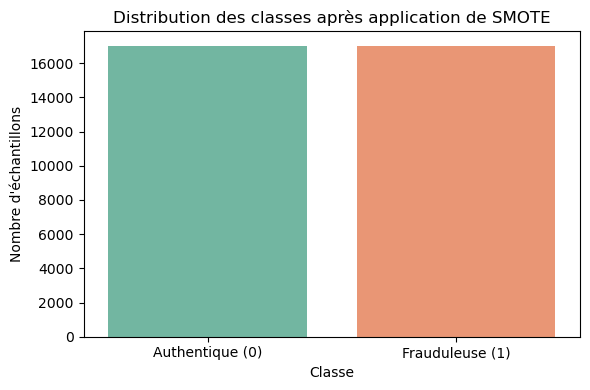

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')
plt.title('Distribution des classes après application de SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.xticks([0, 1], ['Authentique (0)', 'Frauduleuse (1)'])
plt.tight_layout()
plt.show()

Division train/test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensions X_train: {X_train.shape}")
print(f"Dimensions X_test: {X_test.shape}")

Dimensions X_train: (14304, 5000)
Dimensions X_test: (3576, 5000)


Sauvegarde des données préparées

In [78]:
np.save('../Data/X_train.npy', X_train)
np.save('../Data/X_test.npy', X_test)
np.save('../Data/y_train.npy', y_train)
np.save('../Data/y_test.npy', y_test)

Visualisation des mots importants

In [ ]:
def plot_top_tfidf_words(vectorizer, n=20):
    feature_names = vectorizer.get_feature_names_out()
    tfidf_mean = np.mean(X, axis=0)
    sorted_indices = np.argsort(tfidf_mean)[::-1]
    top_indices = sorted_indices[:n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(n), tfidf_mean[top_indices], align='center')
    plt.yticks(range(n), [feature_names[i] for i in top_indices])
    plt.xlabel('Score TF-IDF moyen')
    plt.title(f'Top {n} mots avec les scores TF-IDF les plus élevés')
    plt.tight_layout()
    plt.show()

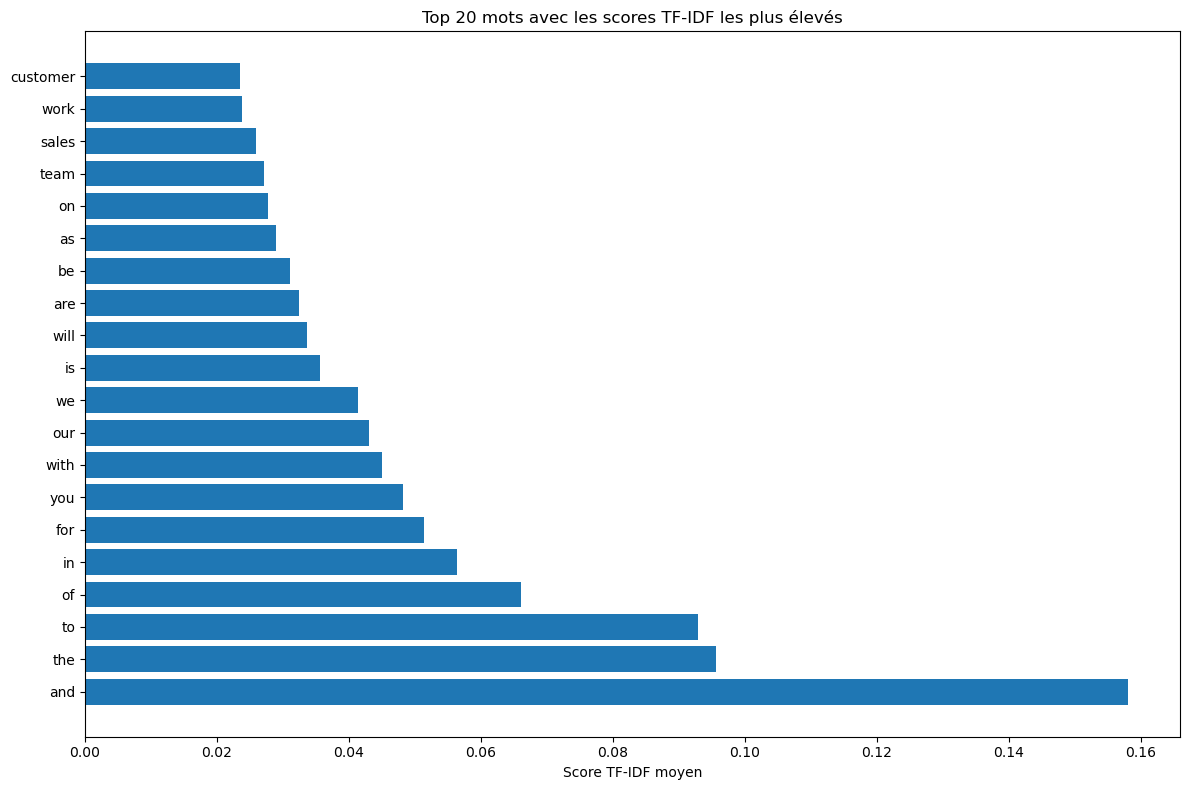

In [80]:
plot_top_tfidf_words(vectorizer)